In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
from dateutil import tz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

In [30]:
[region, zipcode] = ['CAISO','92562']
#[region, zipcode] = ['PJM','08641']
datasource = 'LocusEnergy'

In [31]:
#Load data first
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
dataDir = mainDir + '/data/load/' + region +'/'
loaddata = pd.read_csv(dataDir +'/load_with_full_forecast_integration.csv')
loaddata['tsLocal'] = loaddata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [32]:
loaddata.loc[loaddata['load'].isnull(),['tsLocal','load']]

,tsLocal,load


In [33]:
#for load, make a reference to previous week and previous year 
#Day ahead prediction
loaddata['load-predict-DayAhead-ref'] = 0.5*(loaddata['load-1w']+loaddata['load-1y']) 
#Smootening
loaddata['load-predict-DayAhead-ref+1'] = float('NaN')
loaddata['load-predict-DayAhead-ref-1'] = float('NaN')
loaddata.loc[1:loaddata.shape[0],'load-predict-DayAhead-ref-1'] = list(loaddata['load-predict-DayAhead-ref'].iloc[0:(loaddata.shape[0]-1)])
loaddata.loc[0:(loaddata.shape[0]-2),'load-predict-DayAhead-ref+1'] = list(loaddata['load-predict-DayAhead-ref'].iloc[1:(loaddata.shape[0])])
loaddata['load-predict-DayAhead'] = \
    (loaddata['load-predict-DayAhead-ref']+loaddata['load-predict-DayAhead-ref-1']+loaddata['load-predict-DayAhead-ref+1'])/3.0


In [34]:
#PV data
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'
#we can choose which data to look at.
dataDir = mainDir + '/data/' + datasource +'/' + zipcode +'/'
PVdata = pd.read_csv(dataDir +'/data_with_full_forecast_integration.csv')
PVdata['tsLocal'] = PVdata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

## Data integration

In [35]:
#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15) #Here we are only interested in an hour operation
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,loaddata,on=['tsLocal'], how = 'left') 

In [36]:
index = [(d.columns=='load').nonzero()[0][0], (d.columns=='load-predict-DayAhead').nonzero()[0][0]]
#Interpolate load values to 15 mins
for j in index:
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
            #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

In [37]:
d = pd.merge(d,PVdata,on=['tsLocal'], how = 'left') 

In [38]:
#Check column names needed and make it solid
Data = d
Data_full = Data

In [39]:
#Define scale of PV deployment: maximum load of the year
maxload = np.max(Data_full['load'])
print maxload

43479.84


In [40]:
d_imm = Data_full
d_imm['load-1'] = float('NaN')
d_imm.loc[1:Data.shape[0],'load-1'] = list(d_imm['load'].iloc[0:(d_imm.shape[0]-1)])
maxramprate = np.max(np.absolute(d_imm['load']- d_imm['load-1'])*4)
print maxramprate

4315.41


In [41]:
#We simulate only last quarter of 2014
d = Data_full

#Assign specific period
StartDate = datetime.date(2014,10,1)
offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

Data = d[offset:]
Data = Data.reset_index()
Data.drop('index', axis=1, inplace=True)
Data_original = Data

In [42]:
Data = Data_original

In [43]:
#Set the level of penetration from 0 to 100
level = 15

##Day Ahead Market

Perform day ahead prediction and calculate the ramp rate

In [44]:
def DayAheadPredictionAndRamprate(Data):
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0

    #for PV, use expectedr 
    Data['netload-predict-DayAhead'] =  - PenetrationLevel * Data['mpower'] * Data['expectedr']  * maxload 
    Data['netload-predict-DayAhead'][Data['mpower'].isnull()] = 0
    Data['netload-predict-DayAhead'] = Data['netload-predict-DayAhead'] + Data['load-predict-DayAhead']
    
    return Data
    

Do energy scheduling to match up without exceeding maximum ramp rate

In [45]:
CapRampRateRatio = 1.05

def DayAheadMarketAssignment(Data):
    
    AlertBoolean = 0

    Data['netload-assign-DayAhead'] = float('NaN')
        
    column_index_predict = (Data.columns=='netload-predict-DayAhead').nonzero()[0][0]
    column_index_assign = (Data.columns=='netload-assign-DayAhead').nonzero()[0][0]
    Data.iloc[0, column_index_assign] = Data.iloc[0, column_index_predict]
    for i in range(1,Data.shape[0]):
        if (not np.isnan(Data.iloc[i, column_index_predict])):
            if np.absolute(Data.iloc[i, column_index_predict]-Data.iloc[i-1, column_index_assign])*4 < CapRampRateRatio*maxramprate:
                Data.iloc[i, column_index_assign] = Data.iloc[i, column_index_predict]
            else:
                #can assign at most the max ramprate
                AlertBoolean = 1
                if Data.iloc[i-1, column_index_assign] < Data.iloc[i, column_index_predict]:
                    Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign] + CapRampRateRatio*maxramprate/4
                else:
                    Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign] - CapRampRateRatio*maxramprate/4
        else:
            #prevent null assignment
            Data.iloc[i, column_index_assign] = Data.iloc[i-1, column_index_assign]
            
    if AlertBoolean ==1:
        print "Warning: Day ahead predicted demand exceeds ramp rate capacity"
    
    return Data

##Hour Ahead Market

Perform hour ahead prediction and calculate the ramp rate

In [46]:
def HourAheadPredictionAndRamprate(Data):
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0
    
    #Assign value at 1 hour horizon first
    Data['load-predict-HourAhead'] = float('NaN')
    Data['power-predict-HourAhead'] = float('NaN')
    
    #assign prediction to 15 minutes block. Something like this....
    
    column_index_load_A = (Data.columns=='load_predict_final-A').nonzero()[0][0]
    column_index_load_B = (Data.columns=='load_predict_final-B').nonzero()[0][0]
    column_index_load = (Data.columns=='load-predict-HourAhead').nonzero()[0][0]
    column_index_power_A = (Data.columns=='power_predict_final-A').nonzero()[0][0]
    column_index_power_B = (Data.columns=='power_predict_final-B').nonzero()[0][0]
    column_index_power = (Data.columns=='power-predict-HourAhead').nonzero()[0][0]
    
    #Interpolate load values to 15 mins
    for i in range(0,Data.shape[0]/4-1):
        if (type(Data.iloc[4*i,column_index_load_A])!=pd.tslib.NaTType) & (type(Data.iloc[4*i+4,column_index_load_B])!=pd.tslib.NaTType):
            Data.iloc[4*i,column_index_load] = Data.iloc[4*i,column_index_load_A]
            Data.iloc[4*i+1,column_index_load] = 0.75*Data.iloc[4*i,column_index_load_A]+0.25*Data.iloc[4*i+4,column_index_load_B]
            Data.iloc[4*i+2,column_index_load] = 0.50*Data.iloc[4*i,column_index_load_A]+0.50*Data.iloc[4*i+4,column_index_load_B]
            Data.iloc[4*i+3,column_index_load] = 0.25*Data.iloc[4*i,column_index_load_A]+0.75*Data.iloc[4*i+4,column_index_load_B]
       
         
        #There is no earlier information on solar so just use expected r as before
         
        if (not np.isnan(Data.iloc[4*i,column_index_power_A])) & (not np.isnan(Data.iloc[4*i+4,column_index_power_B])):
            Data.iloc[4*i,column_index_power] = Data.iloc[4*i,column_index_power_A]
            Data.iloc[4*i+1,column_index_power] = 0.75*Data.iloc[4*i,column_index_power_A]+0.25*Data.iloc[4*i+4,column_index_power_B]
            Data.iloc[4*i+2,column_index_power] = 0.50*Data.iloc[4*i,column_index_power_A]+0.50*Data.iloc[4*i+4,column_index_power_B]
            Data.iloc[4*i+3,column_index_power] = 0.25*Data.iloc[4*i,column_index_power_A]+0.75*Data.iloc[4*i+4,column_index_power_B]  
        else:
            Data.iloc[4*i,column_index_power] = Data.loc[4*i,'mpower']*Data.loc[4*i,'expectedr']
            Data.iloc[4*i+1,column_index_power] = Data.loc[4*i+1,'mpower']*Data.loc[4*i+1,'expectedr']
            Data.iloc[4*i+2,column_index_power] = Data.loc[4*i+2,'mpower']*Data.loc[4*i+2,'expectedr']
            Data.iloc[4*i+3,column_index_power] = Data.loc[4*i+3,'mpower']*Data.loc[4*i+3,'expectedr']

    #Combine prediction
    Data['netload-predict-HourAhead'] =  - PenetrationLevel * Data['power-predict-HourAhead'] * maxload 
    Data['netload-predict-HourAhead'][Data['mpower'].isnull()] = 0
    Data['netload-predict-HourAhead'] = Data['netload-predict-HourAhead'] + Data['load-predict-HourAhead']
    
    return Data
    

The ramp rate gets more extreme when it comes to hour ahead market.

In [47]:
CapRampRateRatio = 1.10

def HourAheadMarketAssignment(Data):
    
    AlertBoolean = 0
    
    #Define penetration level as percentage of maxload
    PenetrationLevel = level/100.0   
    
    #Find the actutal load
    Data['netload'] =  - PenetrationLevel * Data['power'] * maxload 
    Data['netload'][Data['mpower'].isnull()] = 0
    Data['netload'] = Data['netload'] + Data['load']

    Data['netload-assign-HourAhead'] = float('NaN')
    
    column_index_actual = (Data.columns=='netload').nonzero()[0][0]
    column_index_predict = (Data.columns=='netload-predict-HourAhead').nonzero()[0][0]
    column_index_assign_day = (Data.columns=='netload-assign-DayAhead').nonzero()[0][0]
    column_index_assign_hour = (Data.columns=='netload-assign-HourAhead').nonzero()[0][0]
    Data.iloc[0, column_index_assign_hour] = Data.iloc[0, column_index_predict]
    for i in range(1,Data.shape[0]):
        if i%4==0:
            #looking at capability to reach net difference between predict hour ahead and assign day ahead within an hour
            if (not np.isnan(Data.iloc[i, column_index_predict])):
                t1 = Data.iloc[i, column_index_predict]-Data.iloc[i-4, column_index_assign_hour]
                t2 = Data.iloc[i, column_index_assign_day]-Data.iloc[i-4, column_index_assign_day]
                if np.absolute(t1-t2) < CapRampRateRatio*maxramprate:
                    Data.iloc[i, column_index_assign_hour] = Data.iloc[i, column_index_predict]
                else:
                    AlertBoolean = 1
                    #can assign at most the max ramprate
                    if t1-t2 > 0:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-4, column_index_assign_hour] + t2 + CapRampRateRatio*maxramprate
                    else:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-4, column_index_assign_hour] + t2 - CapRampRateRatio*maxramprate
            else:
                #prevent null assignment
                Data.iloc[i, column_index_assign_hour] = Data.iloc[i-4, column_index_assign_hour]
        else:
            #looking at capacility to swing between net difference between hour ahead and assign day ahead relative to the next difference
            if (not np.isnan(Data.iloc[i, column_index_predict])):
                t1 = Data.iloc[i, column_index_predict]-Data.iloc[i-1, column_index_assign_hour]
                t2 = Data.iloc[i, column_index_assign_day]-Data.iloc[i-1, column_index_assign_day]
                if np.absolute(t1-t2)*4 < CapRampRateRatio*maxramprate:
                    Data.iloc[i, column_index_assign_hour] = Data.iloc[i, column_index_predict]
                else:
                    AlertBoolean = 1
                    #can assign at most the max ramprate
                    if t1-t2 > 0:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-1, column_index_assign_hour] + t2 + CapRampRateRatio*maxramprate/4
                    else:
                        Data.iloc[i, column_index_assign_hour] = Data.iloc[i-1, column_index_assign_hour] + t2 - CapRampRateRatio*maxramprate/4
            else:
                #prevent null assignment
                Data.iloc[i, column_index_assign_hour] = Data.iloc[i-1, column_index_assign_hour]
                
    if AlertBoolean ==1:
        print "Warning: Hour ahead predicted demand exceeds ramp rate capacity"
        
    return Data
    

In [48]:
AncillaryServiceRatio = 0.05
NumberOfHours = 12
NongenerativeVolume = AncillaryServiceRatio*maxload*NumberOfHours #This is equivalent to NumbeOfHours of power

def AncillaryServiceCount(Data):
    
    AlertBoolean = 0
    count = 0
    
    #Check maximum ramp rate of difference between new prediction and day ahead assignment
    Data['netload-difference'] = Data['netload'] - Data['netload-assign-HourAhead']
    
    Data['Nongenerative-state'] = float('NaN')
    Data.loc[0, 'Nongenerative-state'] = 0.5*NongenerativeVolume #assume there is half energy in the storage
    
    for i in range(1,Data.shape[0]):
        if  Data.loc[i-1, 'Nongenerative-state'] - Data.loc[i, 'netload-difference']/4 <0:
            AlertBoolean = 1
            count = count+1
            Data.loc[i, 'Nongenerative-state'] = 0
        elif Data.loc[i-1, 'Nongenerative-state'] - Data.loc[i, 'netload-difference']/4 > NongenerativeVolume:
            AlertBoolean = 1
            count = count+1
            Data.loc[i, 'Nongenerative-state'] = NongenerativeVolume
        else:
            Data.loc[i, 'Nongenerative-state'] = Data.loc[i-1, 'Nongenerative-state'] - Data.loc[i, 'netload-difference']/4
            
    l = list(((Data['netload']-Data['netload-assign-HourAhead'])/maxload).dropna())
    
    print np.max(l), np.min(l), np.mean(np.absolute(l)),count*1.0/Data.shape[0]
    
    return Data

In [49]:
def imbalanceplot():

    fig = plt.figure(figsize=(10,6))
    ax1  = fig.add_subplot(111)
    #Overall distribution

    l = list(((Data5['netload']-Data5['netload-assign-HourAhead'])/maxload).dropna())

    # the histogram of the data
    n, bins, patches = ax1.hist(l, 60, normed=1, alpha=0.75)

    # best fit of data with normal distribution
    (mu, sigma) = norm.fit(l)
    print mu, sigma

    plt.xlabel("Predicted value - Actual value")
    plt.ylabel("Frequency")

    # add a 'best fit' line
    y = mlab.normpdf( bins, mu, sigma)
    ax1.plot(bins, y, 'r--', linewidth=2)

    laplace = stats.laplace

    # fit
    param = laplace.fit(l)
    x = np.linspace(np.min(l), np.max(l), 100)
    pdf_fitted = laplace.pdf(x, *param)
    plt.plot(x, pdf_fitted, 'g--', linewidth=2)

    print  param
    


In [50]:
#Example use
level = 15 
Data1 = DayAheadPredictionAndRamprate(Data)
Data2 = DayAheadMarketAssignment(Data1)
Data3 = HourAheadPredictionAndRamprate(Data2)
Data4 = HourAheadMarketAssignment(Data3)
Data5 = AncillaryServiceCount(Data4)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0560208694775 -0.0475935914105 0.00626185309187 0.0386096014493


C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


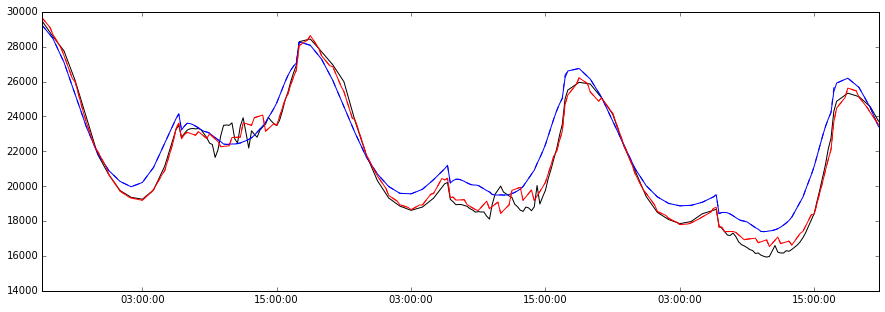

In [51]:
fig = plt.figure(figsize=(5*3, 5*1))
l = range(4200,4500)
#l = range(0,Data5.shape[0])
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='black')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-DayAhead'],color='blue',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-DayAhead'],color='blue',linestyle='-')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-HourAhead'],color='red',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-HourAhead'],color='red',linestyle='-')

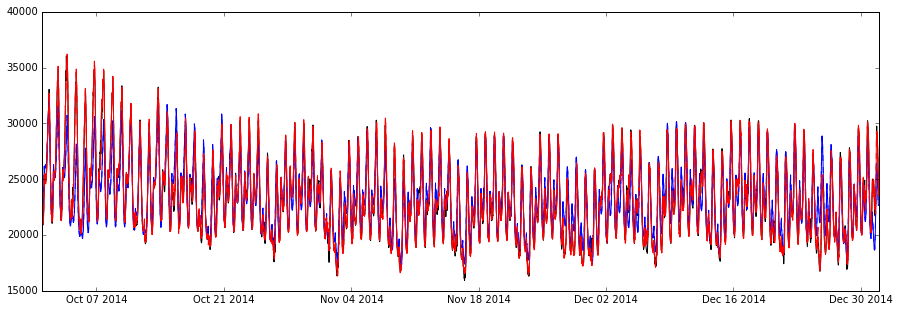

In [52]:
fig = plt.figure(figsize=(5*3, 5*1))
#l = range(4200,4500)
l = range(0,Data5.shape[0])
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='black')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-DayAhead'],color='blue',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-DayAhead'],color='blue',linestyle='-')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-predict-HourAhead'],color='red',linestyle='--')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload-assign-HourAhead'],color='red',linestyle='-')

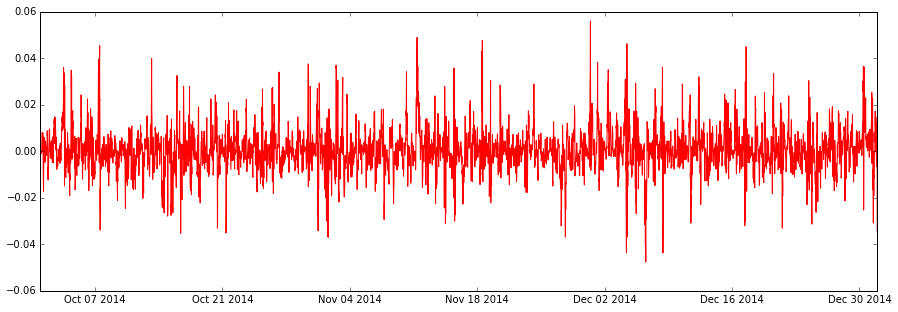

In [53]:
fig = plt.figure(figsize=(5*3, 5*1))
l = range(4000,4500)
l = range(0,Data5.shape[0])
plt.plot(Data5.loc[l,'tsLocal'],(Data5.loc[l,'netload']-Data5.loc[l,'netload-assign-HourAhead'])/maxload,color='red')

In [54]:
np.sum(Data5.loc[l,'netload']-Data5.loc[l,'netload-assign-HourAhead'])/NongenerativeVolume/4, np.mean(Data5.loc[l,'netload']-Data5.loc[l,'netload-assign-HourAhead'])/maxload

(1.7060633457616732, 0.00046397190139694226)

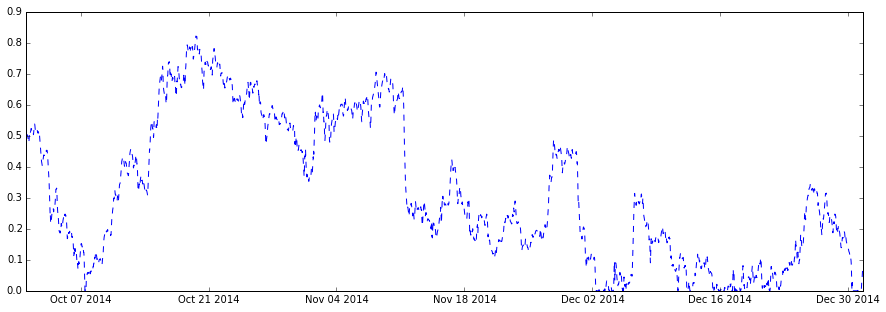

In [55]:
fig = plt.figure(figsize=(5*3, 5*1))
#l = range(4200,4500)
l = range(0,Data.shape[0])
#plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'netload'],color='red')
plt.plot(Data5.loc[l,'tsLocal'],Data5.loc[l,'Nongenerative-state']/NongenerativeVolume,color='blue',linestyle='--')

In [56]:
#Compile all we need
for level in [0,5,10,15,20,25]:
    print "Level: " + str(level)
    Data1 = DayAheadPredictionAndRamprate(Data)
    Data2 = DayAheadMarketAssignment(Data1)
    Data3 = HourAheadPredictionAndRamprate(Data2)
    Data4 = HourAheadMarketAssignment(Data3)
    Data5 = AncillaryServiceCount(Data4)
    #imbalanceplot()

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Level: 0
0.0399530721833 -0.0368692667494 0.00464484520564 0.00101902173913
Level: 5
0.0399530721833 -0.0368692667494 0.00493027340834 0.0100769927536
Level: 10
0.0399530721833 -0.0368692667494 0.00554056328529 0.0288722826087
Level: 15
0.0560208694775 -0.0475935914105 0.00626185309187 0.0386096014493
Level: 20
0.0731498361663 -0.0595107204087 0.0070381423633 0.0450634057971
Level: 25
0.0902788028551 -0.071427849407 0.00784011913917 0.0484601449275


C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
